#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H=13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
E = 210e9

In [20]:
E*Ar

16991625880.187403

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [28]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [29]:
rng = np.random.default_rng()

In [30]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [32]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.78876317,  0.13655569, -0.5993373 ],
       [ 0.06524528, -0.98810308, -0.1392672 ],
       [-0.61122476,  0.07074491, -0.78828894]])

In [33]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.007644


In [34]:
Ret.shape

(50, 3, 3)

In [35]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [36]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float32))) 
    return ans.T

In [37]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000729


In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 3.05398334e+02, -1.13005792e+04,  2.27306425e+04],
       [ 9.74382766e+02, -4.24408222e+03,  2.24902308e+03],
       [-1.51493317e+01, -1.48103806e+03, -1.31354865e+03],
       [ 1.65895250e+04,  6.19241961e+01, -2.13833306e+00],
       [-3.03214330e+03, -3.75234456e+02,  1.72405413e+03],
       [-1.13736063e+04, -1.58540969e+03,  1.40777208e+03],
       [ 1.30195205e+02,  1.97194372e+03,  8.23060531e+03],
       [ 3.99005499e+02,  1.78029567e+04, -2.75580486e+03],
       [ 9.49057129e+03,  6.79248099e+02,  6.28061704e+03],
       [-2.30195599e+03, -5.76639157e+03, -3.48782330e+03],
       [-7.36026535e+03,  2.18627115e+04,  4.60733236e+03],
       [ 8.36268280e+02, -5.05853864e+02,  3.90028236e+03],
       [-1.13303929e+04,  2.26381692e+04, -6.02495162e+03],
       [ 5.17041202e+03, -2.14990262e+03,  7.86580900e+03],
       [ 1.10551135e+02, -3.05727705e+04, -2.25684712e+04],
       [ 3.17690003e+01, -5.41620384e+03,  4.88201773e+03],
       [-4.47586889e+03,  2.10298319e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000319


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.001145


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000127


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [55]:
phi(x,y,z,Ret,None,None)

array([[-0.03403759, -0.7819703 , -0.5676926 ],
       [ 0.3132776 , -1.1070505 ,  0.25860268],
       [ 0.578834  , -1.5003518 ,  0.5159458 ],
       [ 0.00314865,  1.5134122 , -1.0053313 ],
       [ 0.9742015 , -0.13395576, -1.4746737 ],
       [-1.4910895 ,  1.4052291 ,  0.86447316],
       [ 1.2313701 , -0.32720298, -0.20499575],
       [ 0.1514635 ,  0.9495416 , -0.4152016 ],
       [-2.2781603 ,  0.5891265 ,  1.5797304 ],
       [ 0.859487  ,  1.6288246 , -0.8870335 ],
       [-0.87140703,  0.08806261,  0.13593696],
       [-0.36357963,  1.2313975 ,  0.14618456],
       [ 0.29117137,  2.4607618 , -0.22378993],
       [ 0.10072368, -0.54748833,  0.5378264 ],
       [ 1.1224165 ,  1.9017504 , -0.90270746],
       [ 2.0956163 ,  0.4665546 ,  0.7154764 ],
       [-0.9088676 ,  0.7410678 ,  0.54157424],
       [ 0.78924954,  2.6113858 ,  0.4603937 ],
       [-0.61380726, -1.4042878 , -0.6070738 ],
       [-0.14275573, -0.59029657,  2.1604369 ],
       [-0.8768289 , -0.11542529,  1.003

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.001970


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002813


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.003742


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 2.27367886e+00, -6.12848811e-01,  1.91320412e+00],
       [-9.92540132e-01,  4.59712224e-01,  8.76787647e-01],
       [-1.81315112e+00, -1.72253011e-01, -4.98572824e-01],
       [ 1.01375047e+00,  1.07866726e-01, -7.48206215e-01],
       [-9.47520116e-02, -1.01228410e+00, -1.27877361e+00],
       [ 1.04570250e+00, -1.67953016e+00,  1.00223432e+00],
       [ 7.58130240e-01, -1.71493510e-01,  1.03273727e-01],
       [-7.12613866e-01,  4.79760286e-01,  3.62933922e-01],
       [-4.90902161e-01, -2.48905871e-01, -8.55863997e-04],
       [-1.30153263e-01,  4.71876339e-01, -7.78076113e-01],
       [-1.66347230e-01, -4.98562318e-01,  1.21248058e-01],
       [ 1.28177824e-02,  1.17692319e+00, -2.24000710e-01],
       [ 1.38287476e+00,  6.81277975e-01,  2.78310063e-01],
       [-4.69561604e-01,  6.00662377e-01,  4.17396156e-02],
       [ 6.90250164e-01,  5.08347387e-01, -1.92376308e-01],
       [-4.54594732e-01,  1.46770271e-01, -2.18533108e-01],
       [ 1.21169465e+00,  2.40972838e-02

In [63]:
def d_s(f,a,b,c,Ret,omega,force): # here
    
    fun = f(a,b,c,Ret,omega, force) 
#     print(fun)
    if any(force):
#         fun[-1]=-np.array(force)
        fun[-1]=-np.dot(Ret[-1],force)
#         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#     print(fun)
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float32)).T

In [64]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3])

array([[ 2.14275596e-06,  1.36563953e-05,  2.01627736e-05,
        -2.51871826e-05, -1.34070455e-05, -5.40750506e-06,
         1.22205999e-06, -1.36472955e-05,  9.90593933e-06,
        -2.51583289e-05,  4.78738664e-07, -1.08520207e-05,
        -2.68452480e-05,  1.08530387e-05, -2.80442979e-05,
         2.48919286e-06, -1.99491587e-06, -2.15097056e-05,
         7.97206039e-06,  2.75070586e-05,  1.11873942e-05,
         1.32144660e-05,  1.03250826e-05,  3.43737375e-05,
        -1.80448985e-05,  5.05003262e-07, -3.50733912e-05,
         3.16140653e-05, -4.08257236e-06,  2.13558387e-05,
        -8.63340529e-06,  1.69497065e-05, -3.44015809e-05,
         3.93206588e-06, -2.64722253e-05, -9.11300985e-06,
        -1.57198549e-05,  6.21852600e-07, -1.82021830e-05,
         9.59122281e-06,  4.33504229e-06, -3.54880947e-06,
        -1.65782919e-05,  2.74872408e-06,  6.43274251e-06,
         2.95691536e-06,  2.65702063e-05, -1.16487860e-05,
         2.29131321e-05,  5.85332534e-05],
       [ 5.33

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.002450


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[-6.53020226e-07,  1.37885975e-06, -4.94306661e-07,
        -8.26530999e-07, -2.50380039e-06,  1.26235866e-06,
         6.05611120e-07, -1.22945370e-06,  9.98733235e-08,
        -3.20972908e-06,  3.66413524e-08, -9.56539983e-07,
         1.26417835e-06,  1.19323110e-06, -2.55772545e-06,
         8.24562051e-07,  2.59349325e-07,  7.50403483e-07,
         1.20186265e-06, -9.42885795e-07, -4.94301002e-07,
        -1.43859421e-07,  5.18889563e-07, -3.34765933e-07,
         3.04820590e-07,  3.57670418e-07, -2.75663702e-06,
        -8.30973984e-07, -7.03558425e-07, -6.67854474e-07,
         1.43616693e-06,  9.42920008e-07, -3.70890246e-06,
        -1.82766469e-06, -4.70254784e-07, -6.82705403e-07,
        -1.59170480e-06,  6.50486532e-07,  3.88529805e-08,
         2.97239411e-06, -1.04711886e-06, -3.08307899e-06,
        -4.06397293e-07, -2.05477874e-06, -9.17310734e-07,
        -4.94793187e-07, -7.06840403e-07, -2.13183076e-06,
         2.68550651e-06,  1.07011890e-06],
       [ 3.28

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.05398334e+02, -9.74382766e+02,  1.51493317e+01,
        -1.65895250e+04,  3.03214330e+03,  1.13736063e+04,
        -1.30195205e+02, -3.99005499e+02, -9.49057129e+03,
         2.30195599e+03,  7.36026535e+03, -8.36268280e+02,
         1.13303929e+04, -5.17041202e+03, -1.10551135e+02,
        -3.17690003e+01,  4.47586889e+03, -5.05426555e+03,
         6.41495734e+03, -2.74812292e+00,  4.46245620e+03,
        -7.77803031e+03,  6.30998880e+03,  4.91299792e+03,
        -5.36436095e+03,  6.01065296e+03,  2.66341493e+01,
        -5.01861572e+02, -2.00141910e+04, -3.05439981e+04,
        -6.07858089e+02,  8.77854344e+03, -1.71831911e+03,
        -3.77888883e+03,  8.15849904e+03, -9.87688605e+03,
        -2.70729880e+04, -2.46673088e+03, -1.17001458e+04,
        -1.23190313e+04,  9.16958103e+02,  4.96628923e+02,
        -6.35196732e+03,  4.84524556e+03, -9.31647867e+03,
         4.13226024e+03,  7.93374266e+03, -1.03750295e+03,
         7.65018905e+02, -1.78275832e+03],
       [ 1.13

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.002109


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[ 4.43515351e+02, -8.70540879e+02,  4.27024640e+02],
       [-4.74955943e+00, -2.91634629e+02,  2.96384198e+02],
       [ 3.60834938e+01, -9.10224363e+02,  8.74140797e+02],
       [ 2.50707429e+01, -8.34238611e+01,  5.83530681e+01],
       [ 1.19942953e+02,  5.40895164e-02, -1.19997282e+02],
       [-8.60202168e+01, -6.17599215e+01,  1.47780310e+02],
       [-1.80615935e+02, -8.26725066e+02,  1.00734136e+03],
       [-6.82882755e+01, -7.63060491e+02,  8.31348903e+02],
       [ 7.14658484e+01, -6.63242002e+02,  5.91776010e+02],
       [-5.96627242e+01, -5.92677637e+02,  6.52340481e+02],
       [-1.36023336e+02, -2.74931151e+02,  4.10954759e+02],
       [ 2.49837334e+02, -2.01575211e+02, -4.82626220e+01],
       [ 1.15654644e+01, -1.44907639e+02,  1.33342151e+02],
       [-1.03615640e+02, -6.12169962e+02,  7.15785810e+02],
       [ 3.21665110e+02, -3.91220280e+02,  6.95545270e+01],
       [-2.06483425e+02, -8.15392303e+02,  1.02187614e+03],
       [ 2.20848187e+01, -4.70546271e+02

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-4.90726763e+08, -6.37015570e+07,  3.79814256e+08],
       [-2.96359834e+08,  2.46546935e+04, -4.72490966e+06],
       [-8.96465521e+08, -2.23238176e+07,  1.37597122e+07],
       [-1.07071558e+08, -4.87183359e+07, -2.36475683e+07],
       [ 2.84394894e+05, -1.19712769e+08,  2.30304872e+05],
       [-7.05644679e+07,  7.72158438e+07, -8.80446278e+06],
       [-8.73237698e+08,  1.34104405e+08, -4.65117073e+07],
       [-6.50879531e+08,  1.80469820e+08,  1.12181482e+08],
       [-8.09922043e+08, -2.18145003e+08, -1.46679085e+08],
       [-2.93016513e+08,  3.59323902e+08,  2.99661135e+08],
       [-6.25370486e+08, -2.14414901e+08, -3.50438352e+08],
       [-6.29382231e+07, -1.11200676e+08,  1.38636909e+08],
       [-1.23826428e+08,  9.51583422e+06,  2.10813105e+07],
       [-3.80133679e+08,  3.35652197e+08,  2.32036443e+08],
       [-2.99173969e+08, -2.29618931e+08,  9.20465007e+07],
       [-7.27388430e+08,  2.94488173e+08,  8.80045253e+07],
       [-4.48370739e+08,  9.11051517e+04

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000307


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
# def Irho_e(Ret):
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     tmp=Irho.copy()
    
#     tmp1=np.zeros(tmp.shape)
#     np.fill_diagonal(tmp1, vessel_inertia)
#     ans2=np.multiply(np.multiply(Ret,tmp+tmp1),Ret)
    
#     ans1[-1]+=ans2[-1]
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [78]:
Irho_e(Ret)

array([[[6.22147342e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.76347701e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.24279889e+02]],

       [[4.44508577e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.38271689e-03, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 6.06457402e+00]],

       [[9.29728865e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.05017243e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.73759164e+01]],

       [[2.25483385e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.64031702e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 9.73070823e+00]],

       [[4.32467799e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.28729249e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.27335272e-01]],

       [[1.70761644e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.51998357e+01, 0.00000000e+00],
    

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000364


In [80]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [81]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [82]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [83]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.007344


In [84]:
d_me_

array([[ 6.22177476e-14,  4.52660030e-09, -2.88103050e-09],
       [ 4.44530107e-14,  1.56831499e-13, -1.40587691e-10],
       [ 9.29773897e-14,  4.86887081e-10, -4.02804872e-10],
       [ 2.25494306e-14,  3.07862261e-10, -2.25575250e-10],
       [ 4.32488746e-16,  5.96822072e-10, -2.95185973e-12],
       [ 1.70769915e-14,  1.63195537e-09, -4.61873765e-11],
       [ 9.13642031e-14,  2.23469398e-09, -2.27367587e-09],
       [ 7.51082529e-14,  2.12299916e-09, -1.69978527e-09],
       [ 8.68927376e-14,  3.38714962e-09, -3.31997768e-09],
       [ 4.41178852e-14,  2.51930313e-09, -3.98454865e-09],
       [ 7.31328723e-14,  4.37106357e-09, -3.48797997e-09],
       [ 1.58232817e-14,  4.54435363e-09, -7.05997111e-10],
       [ 2.48443918e-14,  1.43106572e-10, -1.20627662e-10],
       [ 5.24782107e-14,  3.08604916e-09, -2.28861158e-09],
       [ 4.47337889e-14,  1.53412431e-09, -1.59997689e-09],
       [ 8.08845117e-14,  3.22652971e-09, -3.70401384e-09],
       [ 5.85840146e-14,  8.05771345e-13

In [85]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [86]:
ne_(dx,dy,dz,DT,Ret)

array([[-3.05398334e+02, -9.74382766e+02,  1.51493317e+01,
        -1.65895250e+04,  3.03214330e+03,  1.13736063e+04,
        -1.30195205e+02, -3.99005499e+02, -9.49057129e+03,
         2.30195599e+03,  7.36026535e+03, -8.36268280e+02,
         1.13303929e+04, -5.17041202e+03, -1.10551135e+02,
        -3.17690003e+01,  4.47586889e+03, -5.05426555e+03,
         6.41495734e+03, -2.74812292e+00,  4.46245620e+03,
        -7.77803031e+03,  6.30998880e+03,  4.91299792e+03,
        -5.36436095e+03,  6.01065296e+03,  2.66341493e+01,
        -5.01861572e+02, -2.00141910e+04, -3.05439981e+04,
        -6.07858089e+02,  8.77854344e+03, -1.71831911e+03,
        -3.77888883e+03,  8.15849904e+03, -9.87688605e+03,
        -2.70729880e+04, -2.46673088e+03, -1.17001458e+04,
        -1.23190313e+04,  9.16958103e+02,  4.96628923e+02,
        -6.35196732e+03,  4.84524556e+03, -9.31647867e+03,
         4.13226024e+03,  7.93374266e+03, -1.03750295e+03,
         7.65018905e+02, -1.78275832e+03],
       [ 1.13

### Static solution

In [87]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [88]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [89]:
Fx_0=82945396

In [90]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [91]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [92]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [93]:
delta_x=horizontal_length/(node_N-1)

In [94]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [95]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [96]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

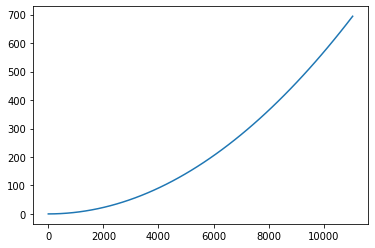

In [97]:
plt.plot(x0, z0)
plt.show()

In [98]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [99]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [100]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3]).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [106]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [107]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [108]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

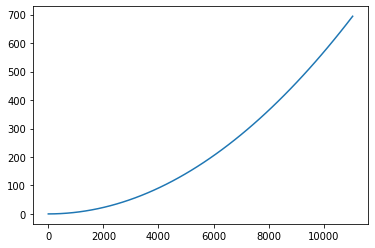

In [109]:
plt.plot(x0_, z0_)
plt.show()

In [153]:
init=1e-4
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
        q0[(j-1)*node_N]=0
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*np.array([0.13 for x in range(node_N)])
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*np.array([-0.13 for x in range(node_N)])
#         q0[(j-1)*node_N]=0    
q0[9*node_N-1]=0.13  # here

In [154]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [155]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [156]:
vehicle=semisub('DPcontrol',0,10,40.0,0,0) 

In [157]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [158]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

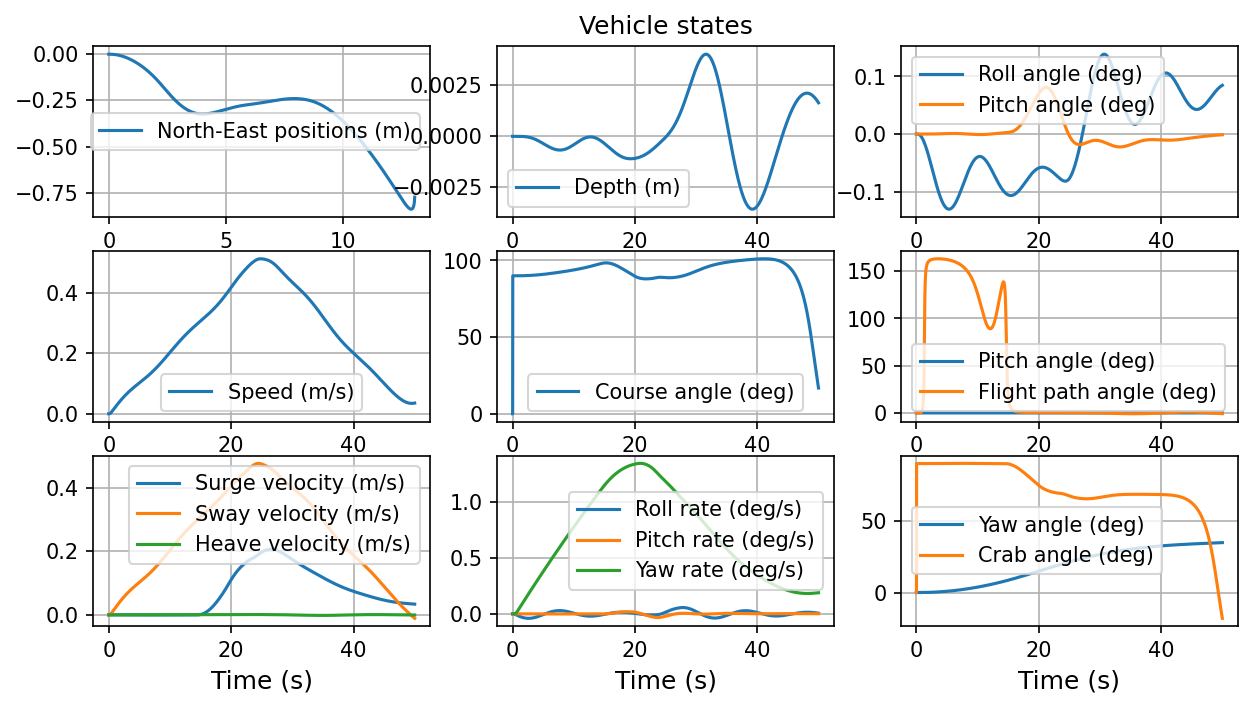

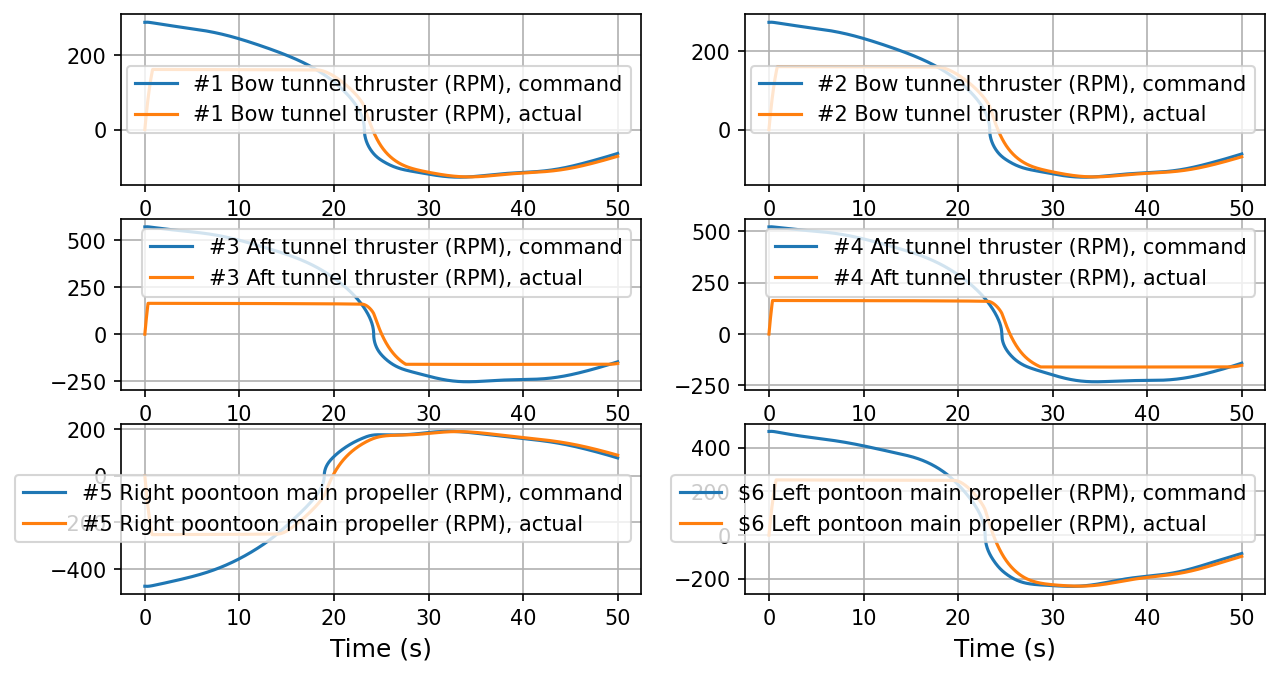

In [159]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [160]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

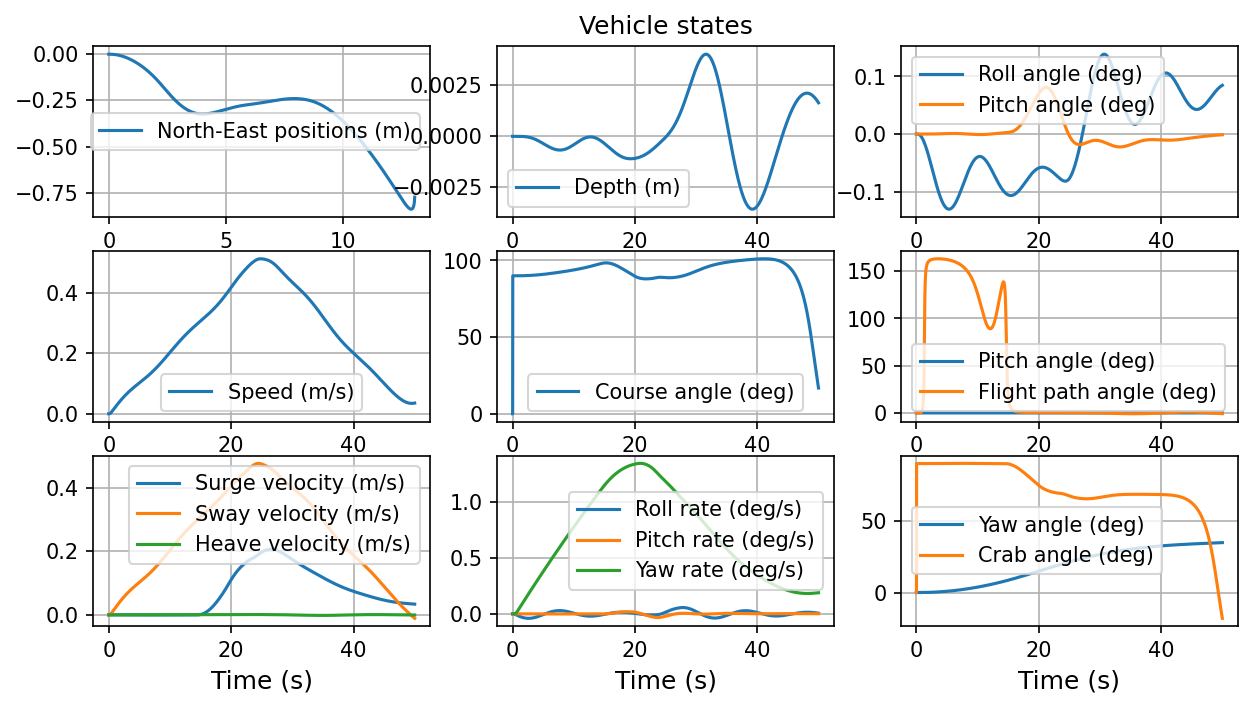

In [161]:
plotVehicleStates(simTime, simData, 3)

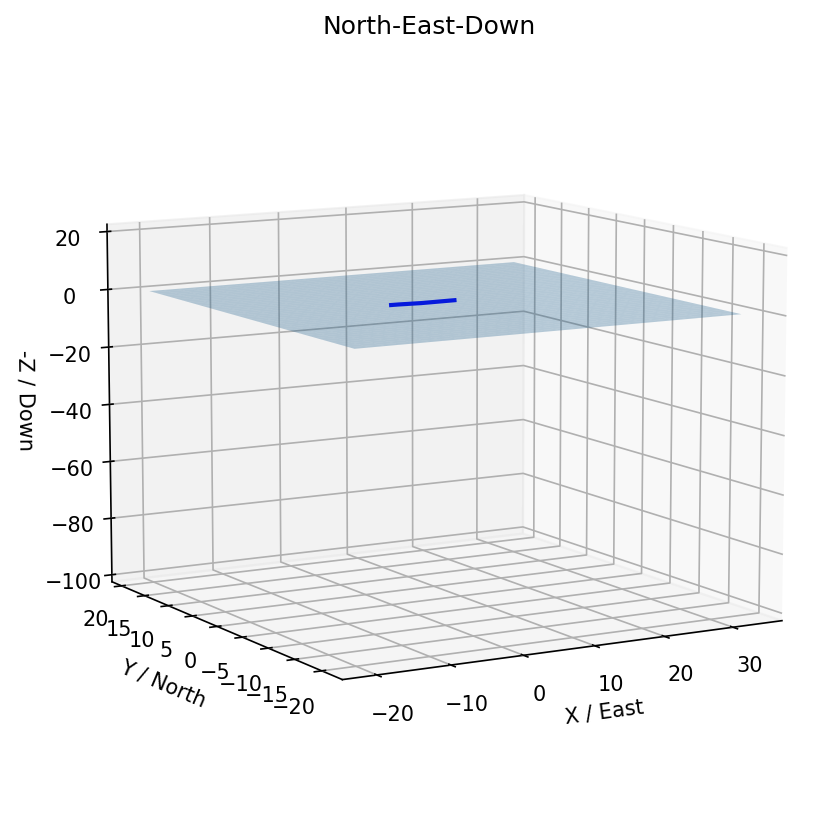

In [162]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [163]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [164]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [165]:
ssa(simData[:, 4][0+10])

4.440892098500626e-16

### Dynamics

In [191]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
    print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]

    
    Z0=np.dot(Re_b(Ret.astype(np.float32)),tau_force[:3].astype(np.float32)).astype(np.float32)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3]).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
   

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    
#     hack=1e20
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [192]:
tspan = (0., 2e-9)

In [193]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  0.00000000e+00]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01  0.00000000e+00]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01  0.00000000e+00]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01  0.00000000e+00]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01  0.00000000e+00]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  6.43864613e-40]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -7.42975540e-38]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -6.18578507e-38]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -3.13806926e-38]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -3.72565217e-37]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  2.09384462e-38]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -2.41615287e-36]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -2.01161432e-36]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -1.02049861e-36]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -1.21158029e-35]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  1.71964512e-36]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -1.98435235e-34]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -1.65211053e-34]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -8.38121146e-35]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -9.95053838e-34]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  4.30576065e-34]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -4.96855205e-32]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -4.13666311e-32]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -2.09854290e-32]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -2.49148131e-31]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  1.99121144e-31]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -2.29772123e-29]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -1.91301179e-29]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -9.70477221e-30]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -1.15219272e-28]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  3.56496019e-29]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -4.11371920e-27]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -3.42495566e-27]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -1.73749135e-27]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -2.06282522e-26]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  9.14012304e-28]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -1.05470742e-25]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -8.78116850e-26]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -4.45471587e-26]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -5.28883223e-25]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  8.60273796e-26]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -9.92696872e-24]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -8.26488782e-24]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -4.19280497e-24]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -4.97788023e-23]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  2.59791856e-24]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -2.99781958e-22]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -2.49589208e-22]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -1.26617432e-22]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -1.50325716e-21]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204015e-06]
  [ 6.30869178e-06  1.00000000e+00  8.03408850e-23]
  [-4.99204015e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -9.27078630e-21]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969390e-05]
  [ 6.00435230e-05  9.99999998e-01 -7.71857059e-21]
  [ 1.67969390e-05 -1.00854739e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831195e-05  6.26158775e-06]
  [-6.12831195e-05  9.99999998e-01 -3.91565643e-21]
  [-6.26158774e-06 -3.83729630e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473844e-04 -2.25711081e-05]
  [ 1.61473844e-04  9.99999987e-01 -4.64883744e-20]
  [ 2.25711078e-05 -3.64464360e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460489e-04  2.96922773e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869178e-06  4.99204016e-06]
  [ 6.30869178e-06  1.00000000e+00  1.37676169e-20]
  [-4.99204016e-06  3.14932427e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190166e-05]
  [ 1.09997581e-04  9.99999994e-01 -1.58868842e-18]
  [ 1.65190165e-05 -1.81705186e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435230e-05 -1.67969391e-05]
  [ 6.00435231e-05  9.99999998e-01 -1.32269296e-18]
  [ 1.67969390e-05 -1.00854740e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831196e-05  6.26158777e-06]
  [-6.12831196e-05  9.99999998e-01 -6.71006521e-19]
  [-6.26158776e-06 -3.83729631e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473845e-04 -2.25711082e-05]
  [ 1.61473845e-04  9.99999987e-01 -7.96648095e-18]
  [ 2.25711079e-05 -3.64464362e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460490e-04  2.96922774e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869179e-06  4.99204017e-06]
  [ 6.30869179e-06  1.00000000e+00  5.23627079e-20]
  [-4.99204017e-06  3.14932428e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190167e-05]
  [ 1.09997581e-04  9.99999994e-01 -6.04229685e-18]
  [ 1.65190166e-05 -1.81705187e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435233e-05 -1.67969392e-05]
  [ 6.00435233e-05  9.99999998e-01 -5.03062991e-18]
  [ 1.67969392e-05 -1.00854740e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831199e-05  6.26158783e-06]
  [-6.12831199e-05  9.99999998e-01 -2.55205523e-18]
  [-6.26158782e-06 -3.83729635e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473846e-04 -2.25711085e-05]
  [ 1.61473846e-04  9.99999987e-01 -3.02991085e-17]
  [ 2.25711082e-05 -3.64464366e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460491e-04  2.96922778e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869179e-06  4.99204017e-06]
  [ 6.30869179e-06  1.00000000e+00  5.74818808e-20]
  [-4.99204017e-06  3.14932428e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190167e-05]
  [ 1.09997581e-04  9.99999994e-01 -6.63301424e-18]
  [ 1.65190166e-05 -1.81705187e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435233e-05 -1.67969392e-05]
  [ 6.00435233e-05  9.99999998e-01 -5.52244299e-18]
  [ 1.67969392e-05 -1.00854740e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831199e-05  6.26158784e-06]
  [-6.12831199e-05  9.99999998e-01 -2.80155363e-18]
  [-6.26158783e-06 -3.83729636e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473846e-04 -2.25711085e-05]
  [ 1.61473846e-04  9.99999987e-01 -3.32612620e-17]
  [ 2.25711082e-05 -3.64464367e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460491e-04  2.96922779e-05]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.00000000e+00 -6.30869179e-06  4.99204017e-06]
  [ 6.30869179e-06  1.00000000e+00  7.10377284e-20]
  [-4.99204017e-06  3.14932428e-11  1.00000000e+00]]

 [[ 9.99999994e-01 -1.09997581e-04 -1.65190167e-05]
  [ 1.09997581e-04  9.99999994e-01 -8.19726596e-18]
  [ 1.65190166e-05 -1.81705187e-09  1.00000000e+00]]

 [[ 9.99999998e-01 -6.00435234e-05 -1.67969392e-05]
  [ 6.00435234e-05  9.99999998e-01 -6.82479070e-18]
  [ 1.67969392e-05 -1.00854741e-09  1.00000000e+00]]

 [[ 9.99999998e-01  6.12831200e-05  6.26158786e-06]
  [-6.12831200e-05  9.99999998e-01 -3.46223894e-18]
  [-6.26158785e-06 -3.83729637e-10  1.00000000e+00]]

 [[ 9.99999987e-01 -1.61473846e-04 -2.25711086e-05]
  [ 1.61473846e-04  9.99999987e-01 -4.11052051e-17]
  [ 2.25711083e-05 -3.64464368e-09  1.00000000e+00]]

 [[ 9.99999984e-01 -1.77460492e-04  2.96922781e-05]


### Results

In [169]:
fin=us

In [170]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 128
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 3.81983872e-20, 2.29615928e-19, 1.19580578e-18,
       6.07099280e-18, 3.06688234e-17, 1.54791173e-16, 7.81237045e-16,
       3.94429100e-15, 1.99114825e-14, 1.00511424e-13, 5.07567728e-13,
       2.56350736e-12, 1.29508560e-11, 6.54242638e-11, 3.29581314e-10,
       9.38725747e-10, 1.58238258e-09, 1.76661586e-09, 1.95084915e-09,
       2.00000000e-09])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.25564997e+02,  2.25564997e+02,  2.25564997e+02, ...,
         2.25564997e+02,  2.25564997e+02,  2.25564997e+02],
       [ 4.51129994e+02,  4.51129994e+02,  4.51129994e+02, ...,
         4.51129994e+02,  4.51129994e+02,  4.51129994e+02],
       ...,
       [ 0.00000000e+00, -3.648

In [171]:
t=fin.t

In [172]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


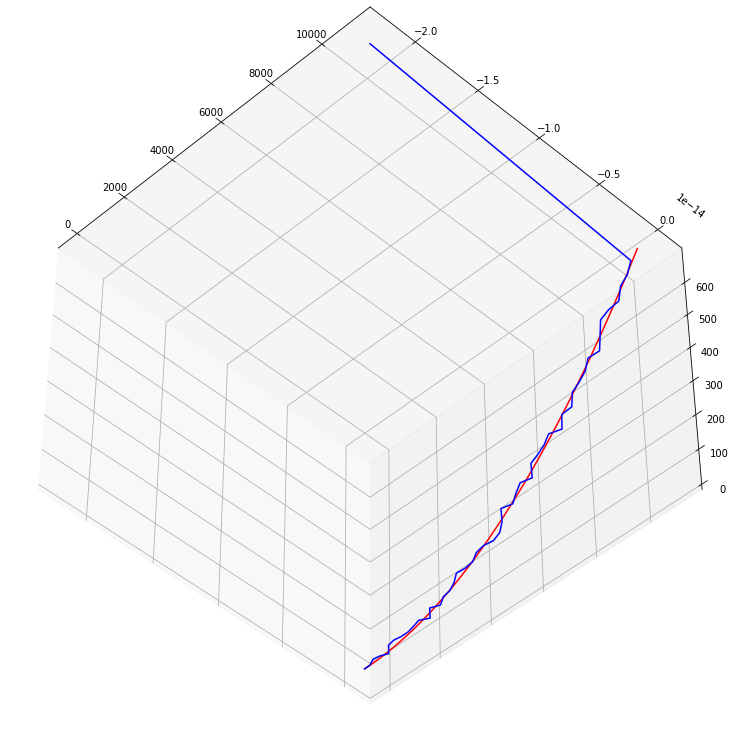

In [173]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [174]:
X,Y,Z

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([ 0.00000000e+00, -1.33976437e-17, -2.33603147e-16, -1.27518635e-16,
         1.3014172

In [175]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [176]:
us=fin.T

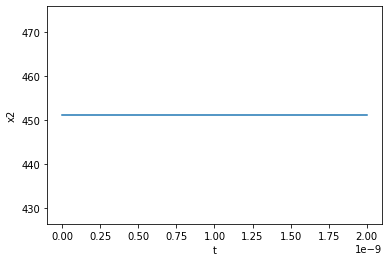

In [177]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

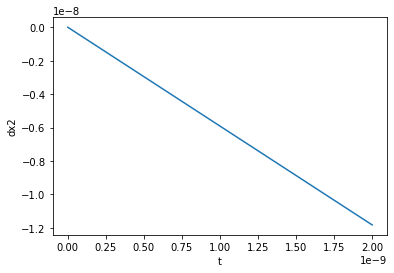

In [178]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

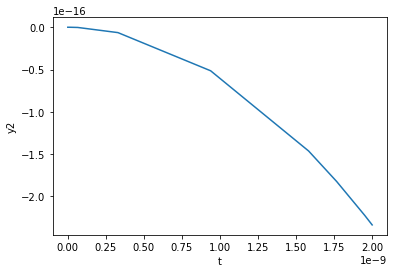

In [179]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

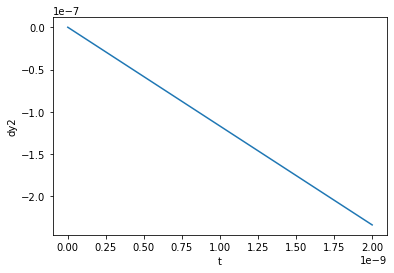

In [180]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

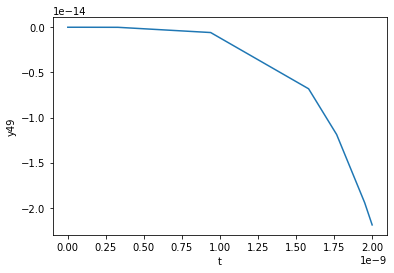

In [181]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

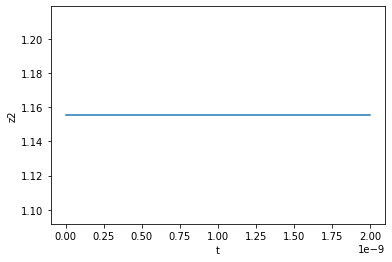

In [182]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

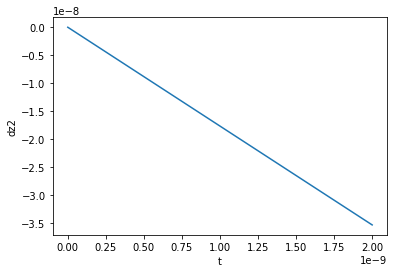

In [183]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

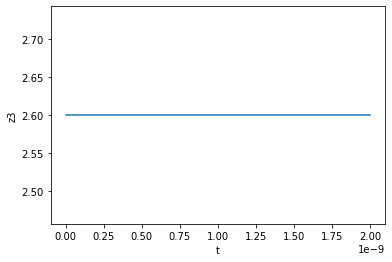

In [184]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

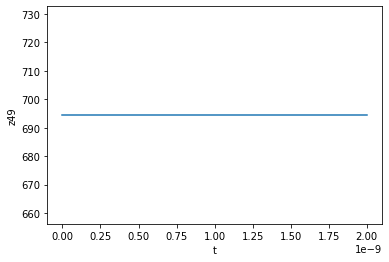

In [185]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

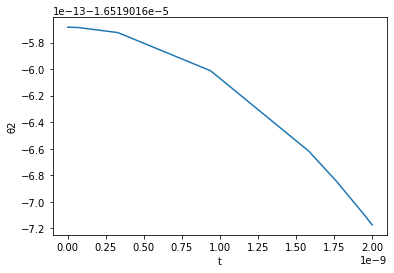

In [186]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

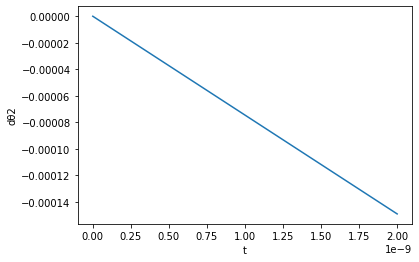

In [187]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

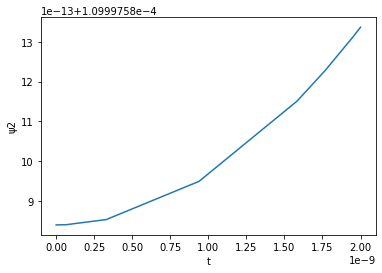

In [188]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

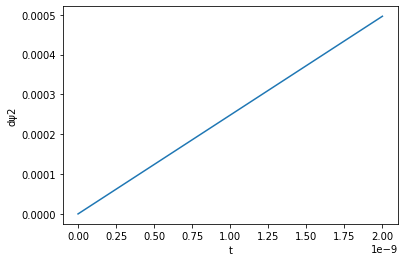

In [189]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()